In [1]:
import tensorflow as tf
import numpy as np
import sklearn
import random,os,io
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint,CSVLogger
from tensorboard.plugins.hparams import api as hp

In [2]:
import pandas as pd
dep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat",sep='\s+',names=['target'])
dep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XV.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yV.dat",sep='\s+',names=["target"])
dep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XT.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yT.dat",sep='\s+',names=["target"])

dep_train.shape,indep_train.shape,dep_val.shape,indep_val.shape,dep_test.shape,indep_test.shape

((42039, 16), (42039, 1), (10935, 16), (10935, 1), (10934, 16), (10934, 1))

In [3]:
dep_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000
mean,-0.248356,-0.004138,-0.002063,-0.000411,-0.000244,0.000038,0.000032,-0.955813,0.001766,-0.002187,-0.001022,-0.000561,0.000159,-0.000144,0.451158,2.030716
std,0.143186,0.017691,0.006818,0.002907,0.002112,0.001049,0.000804,0.314483,0.040846,0.019695,0.008817,0.004493,0.002566,0.001893,0.086088,1.827649
min,-0.497415,-0.136435,-0.038454,-0.014248,-0.008885,-0.006627,-0.003817,-1.499592,-0.227272,-0.101638,-0.059503,-0.036878,-0.014407,-0.009225,0.300213,-1.198834
25%,-0.371456,-0.015947,-0.006744,-0.002432,-0.001656,-0.000697,-0.000500,-1.227219,-0.023441,-0.016485,-0.007183,-0.003799,-0.001689,-0.001545,0.377545,0.466435
50%,-0.247950,-0.003717,-0.002128,-0.000507,-0.000342,-0.000014,0.000057,-0.956767,0.004604,-0.004193,-0.001187,-0.000539,0.000047,-0.000227,0.452744,2.031259
75%,-0.125162,0.007631,0.002595,0.001448,0.001014,0.000713,0.000558,-0.686958,0.030148,0.010435,0.004850,0.002828,0.001818,0.001189,0.524987,3.600611
max,0.000064,0.065562,0.038597,0.019244,0.012764,0.005687,0.007473,-0.403419,0.300085,0.097836,0.037676,0.017639,0.022246,0.008829,0.599638,5.194131


In [4]:
indep_train.describe()

,target
count,42039.000000
mean,0.011824
std,0.003658
min,0.007400
25%,0.009818
50%,0.011084
75%,0.012735
max,0.070915


In [5]:
class SobolevNetwork(Model):
    def __init__(self, input_dim, num_hidden,init = None):
        super(SobolevNetwork, self).__init__()
        self.input_dim = input_dim 
        self.num_hidden = num_hidden
        self.W1 = tf.Variable(tf.random.normal([self.input_dim, self.num_hidden],stddev=0.1))
        self.b1 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp1 = tf.keras.layers.Dropout(0.2)
        self.W2 = tf.Variable(tf.random.normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b2 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp2 = tf.keras.layers.Dropout(0.2)
        self.W3 = tf.Variable(tf.random.normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b3 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp3 = tf.keras.layers.Dropout(0.2)
        self.W4 = tf.Variable(tf.random.normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b4 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp4 = tf.keras.layers.Dropout(0.2)
        self.W5 = tf.Variable(tf.random.normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b5 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp5 = tf.keras.layers.Dropout(0.2)
        self.W6 = tf.Variable(tf.random.normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b6 = tf.Variable(tf.ones([self.num_hidden]))
        self.dp6 = tf.keras.layers.Dropout(0.2)        
        self.W7 = tf.Variable(tf.random.normal([self.num_hidden, 1],stddev=0.1))
        self.b7 = tf.Variable(tf.ones([1]))
        self.w = [(self.W1, self.b1), (self.W2, self.b2), (self.W3, self.b3),(self.W4, self.b4), (self.W5, self.b5), (self.W6, self.b6),(self.W7, self.b7)]
        
    def call(self, X):
        #Input layer
        out = X
        #Hidden layers
        W,b = self.w[0]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        out = self.dp1(out)
        W,b = self.w[1]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        out = self.dp2(out)
        W,b = self.w[2]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        out = self.dp3(out)
        W,b = self.w[3]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        out = self.dp4(out)
        W,b = self.w[4]
        out = tf.nn.leaky_relu(tf.matmul(out, W) + b)
        out = self.dp5(out)
        W,b = self.w[5]
        out = tf.nn.relu(tf.matmul(out, W) + b)
        #Output layer
        W,b = self.w[-1]
        out = tf.matmul(out, W) + b
        return out


In [6]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has loss[mean_absolute_error] of {}".format(epoch+1, logs["loss"]))

    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has loss[mean_absolute_error] of {}".format(batch+1, logs))

In [7]:
csv_callback = CSVLogger( 'logs.csv',separator=',',append=True)

In [8]:
es_callback = EarlyStopping( monitor='val_loss',min_delta=0,patience=2, verbose=1, mode="auto", baseline=None, restore_best_weights=False)

In [9]:
def schedular(epoch, lr):
    if epoch <= 3:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    

    # with train_writer.as_default():
    #     tf.summary.scalar('LearningRateScheduler', data= learning_rate, step= epoch)
    
    return learning_rate

schedular_callback = LearningRateScheduler(schedular, verbose=1)

In [10]:
num_hidden_1 = 12

In [11]:
custom_snn= SobolevNetwork(input_dim=16,num_hidden=num_hidden_1)

In [12]:
from sklearn.metrics import r2_score

In [23]:
custom_snn.compile(optimizer=tf.keras.optimizers.Adam(),  
            loss='mean_absolute_error',metrics=["mean_squared_error","mean_absolute_error","mean_absolute_percentage_error","mean_squared_logarithmic_error"],run_eagerly=True)

In [14]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [15]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
dep_train_ss= pd.DataFrame(ss.fit_transform(dep_train))
dep_val_ss= pd.DataFrame(ss.transform(dep_val))
dep_test_ss= pd.DataFrame(ss.transform(dep_test))

In [16]:
dep_train_ss.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04,4.203900e+04
mean,1.133701e-16,1.243775e-16,-1.429037e-16,3.735868e-17,1.960552e-16,2.026126e-17,6.397139e-17,-3.126076e-16,2.550946e-17,-2.887863e-17,-1.310617e-16,9.100401e-17,-8.184788e-17,3.458306e-18,1.065876e-15,-1.889114e-15
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.739425e+00,-7.478131e+00,-5.337138e+00,-4.760275e+00,-4.091860e+00,-6.351592e+00,-4.788900e+00,-1.729144e+00,-5.607404e+00,-5.049549e+00,-6.632866e+00,-8.083431e+00,-5.676416e+00,-4.797768e+00,-1.753407e+00,-1.767072e+00
25%,-8.597252e-01,-6.675516e-01,-6.865854e-01,-6.953154e-01,-6.685763e-01,-7.004953e-01,-6.623642e-01,-8.630342e-01,-6.171298e-01,-7.259875e-01,-6.987723e-01,-7.208950e-01,-7.202097e-01,-7.400159e-01,-8.551083e-01,-8.559080e-01
50%,2.834259e-03,2.375580e-02,-9.484321e-03,-3.284211e-02,-4.649756e-02,-4.942010e-02,3.059965e-02,-3.033257e-03,6.948886e-02,-1.018696e-01,-1.867750e-02,4.877867e-03,-4.388725e-02,-4.399778e-02,1.841595e-02,2.975047e-04
75%,8.603870e-01,6.652526e-01,6.831795e-01,6.396575e-01,5.957895e-01,6.433655e-01,6.542139e-01,8.549207e-01,6.948614e-01,6.408546e-01,6.659730e-01,7.542428e-01,6.466437e-01,7.039838e-01,8.576049e-01,8.589801e-01
max,1.734967e+00,3.939765e+00,5.963242e+00,6.762325e+00,6.159264e+00,5.383953e+00,9.257489e+00,1.756538e+00,7.303540e+00,5.078544e+00,4.389104e+00,4.050774e+00,8.607465e+00,4.740577e+00,1.724766e+00,1.730886e+00


In [27]:
custom_snn.fit(dep_train, indep_train, validation_data=(dep_val,indep_val),batch_size = 1000, epochs = 8, callbacks=[schedular_callback,LossCallback(), csv_callback,tensorboard_callback])

ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.

In [18]:
custom_snn

In [20]:
import dalex as dx 

In [19]:
# compute SHAP values
import shap
tf.compat.v1.disable_v2_behavior()
background = dep_train.iloc[np.random.choice(dep_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(custom_snn, dep_train)
shap_values = explainer.shap_values(dep_test)

Instructions for updating:
non-resource variables are not supported in the long term


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


TypeError: object of type 'NoneType' has no len()

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

In [36]:
indep_test.head()

,target
0,0.016498
1,0.014071
2,0.016428
3,0.012589
4,0.013429


In [33]:
custom_snn.evaluate(dep_test, indep_test)

TypeError: 'NoneType' object is not callable

In [31]:
custom_snn.predict(dep_test)

342/342 [==============================] - 2s 4ms/step


array([[0.01232105],
       [0.01232111],
       [0.01232111],
       ...,
       [0.01232111],
       [0.01232111],
       [0.01232105]], dtype=float32)

In [16]:
custom_snn.save("final1")

INFO:tensorflow:Assets written to: final1\assets


In [19]:
custom_snn.fit(dep_train_ss, indep_train, validation_data=(dep_val_ss,indep_val),batch_size = 1000, epochs = 8, callbacks=[schedular_callback,LossCallback(), csv_callback,tensorboard_callback])



Epoch 1: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 1/8

 For Batch Number 1 the model has loss[mean_absolute_error] of {'loss': 0.003126361407339573}
 1/43 [..............................] - ETA: 28s - loss: 0.0031
 For Batch Number 2 the model has loss[mean_absolute_error] of {'loss': 0.00313993520103395}

 For Batch Number 3 the model has loss[mean_absolute_error] of {'loss': 0.0030545908957719803}

 For Batch Number 4 the model has loss[mean_absolute_error] of {'loss': 0.002987976185977459}
 4/43 [=>............................] - ETA: 0s - loss: 0.0030 
 For Batch Number 5 the model has loss[mean_absolute_error] of {'loss': 0.0030163717456161976}

 For Batch Number 6 the model has loss[mean_absolute_error] of {'loss': 0.0030706014949828386}

 For Batch Number 7 the model has loss[mean_absolute_error] of {'loss': 0.003112067934125662}
 7/43 [===>..........................] - ETA: 0s - loss: 0.0031
 For Batch Number 8 the model has loss[mean_absolut

In [ ]:
custom_snn.predict(dep_test_ss)


In [20]:
custom_snn.evaluate(dep_test_ss, indep_test)


342/342 [==============================] - 1s 3ms/step - loss: 0.0025


0.0024894324596971273

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17416), started 5 days, 1:03:26 ago. (Use '!kill 17416' to kill it.)

In [17]:
%reload_ext tensorboard

In [22]:
from tensorboard.plugins.hparams import api as hp

In [54]:
def model_builder(hp):
  # model = tf.keras.Sequential()
  # model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
  # hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
#   model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
#   model.add(tf.keras.layers.Dense(10, activation='softmax'))
  model= SobolevNetwork(input_dim=16,num_hidden=hp_layer_1)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error', metrics=["mean_squared_error"])
  
  return model

In [27]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

INFO:tensorflow:Reloading Oracle from existing project dir\x\oracle.json


In [28]:
tuner.search(dep_train, indep_train, epochs=50, validation_split=0.2, callbacks=[es_callback])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
901               |?                 |layer_1
0.01              |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
1051/1051 [==============================] - 90s 83ms/step - loss: 1.5470 - val_loss: 0.0431
Epoch 2/2
1051/1051 [==============================] - 93s 89ms/step - loss: 0.0095 - val_loss: 0.0036


KeyError: 'mse'

In [29]:
from tensorflow.keras import datasets

(X_train_reg, Y_train_reg), (X_test_reg, Y_test_reg) = datasets.boston_housing.load_data()

X_train_reg.shape, X_test_reg.shape, Y_train_reg.shape, Y_test_reg.shape

57026/57026 [==============================] - 0s 1us/step


((404, 13), (102, 13), (404,), (102,))

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

def build_model(hyperparams):
    model = Sequential()
    model.add(layers.Input(shape=(X_train_reg.shape[1],)))
    model.add(layers.Dense(units=hyperparams.Int("units_l1", 16, 50, step=16),
                           use_bias=hyperparams.Boolean("bias_l1"),
                           activation=hyperparams.Choice("act_l1", ["relu", "tanh"])
                          ))
    model.add(layers.Dense(units=hyperparams.Int("units_l2", 16, 50, step=16),
                           use_bias=hyperparams.Boolean("bias_l2"),
                           activation=hyperparams.Choice("act_l2", ["relu", "tanh"])
                          ))
    model.add(layers.Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_squared_error"])

    return model

In [55]:
from keras_tuner import RandomSearch
from keras_tuner import Objective

tuner1 =  RandomSearch(hypermodel=model_builder,
                      objective="val_mean_squared_error",
                      #objective=Objective(name="val_mean_squared_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="Regression2",
                      overwrite=True
                    )

# tuner1.search(X_train_reg, Y_train_reg, batch_size=32, epochs=10, validation_data=(X_test_reg, Y_test_reg))
tuner1.search(dep_train, indep_train, batch_size=32, epochs=3, validation_data=(dep_val, indep_val))


Trial 5 Complete [00h 03m 03s]
val_mean_squared_error: 0.010796456597745419

Best val_mean_squared_error So Far: 0.00012853762018494308
Total elapsed time: 00h 12m 04s
INFO:tensorflow:Oracle triggered exit


In [56]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'layer_1': 101, 'learning_rate': 0.01}

In [33]:
best_model = tuner1.get_best_models()[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [40]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2
from keras_tuner.tuners import RandomSearch, Hyperband
tuner= Hyperband(build_model,
                   objective= 'val_mean_squared_error',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='houseprices',
                   overwrite=True)

In [41]:

tuner.search(x= X_train_reg,
             y= Y_train_reg,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test_reg, Y_test_reg),
             verbose=0,
             
            )
# tuner1.search(X_train_reg, Y_train_reg, batch_size=32, epochs=10, validation_data=(X_test_reg, Y_test_reg))

c:\Users\kiran.franklin\Anaconda3\lib\site-packages\keras_tuner\engine\metrics_tracking.py:105: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.get_best_hyperparameters()

In [44]:
# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [49]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_l1')},
second layer is {best_hps.get('units_l2')} 
  


""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test_reg, Y_test_reg)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 32,
second layer is 32 
  



[]


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [2]:
import SCCAF

c:\Users\kiran.franklin\Anaconda3\envs\new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%pylab inline

import warnings
warnings.filterwarnings("ignore")
from SCCAF import *
import urllib.request

Populating the interactive namespace from numpy and matplotlib


In [31]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt, pandas as pd
n=1000
m1=-3
m2=3

df1 = pd.DataFrame((np.random.randn(n)+m1).reshape(-1,2), columns=['x','y'])
df2 = pd.DataFrame((np.random.randn(n)+m2).reshape(-1,2), columns=['x','y'])
df3 = pd.DataFrame(df1.values+df2.values, columns=['x','y'])
df1['kind'] = 'dist1'
df2['kind'] = 'dist2'
df3['kind'] = 'dist1+dist2'
df=pd.concat([df1,df2,df3])

In [34]:
df

,x,y,kind
0,-3.753974,-1.946866,dist1
1,-2.094135,-2.135739,dist1
2,-3.679683,-3.662364,dist1
3,-3.397475,-3.334732,dist1
4,-3.287789,-3.074728,dist1
...,...,...,...
495,-0.078494,-1.545800,dist1+dist2
496,0.984191,-1.273090,dist1+dist2
497,-1.700730,-0.423822,dist1+dist2
498,-1.815766,-1.127050,dist1+dist2


In [32]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    plt.legend(legends)
    

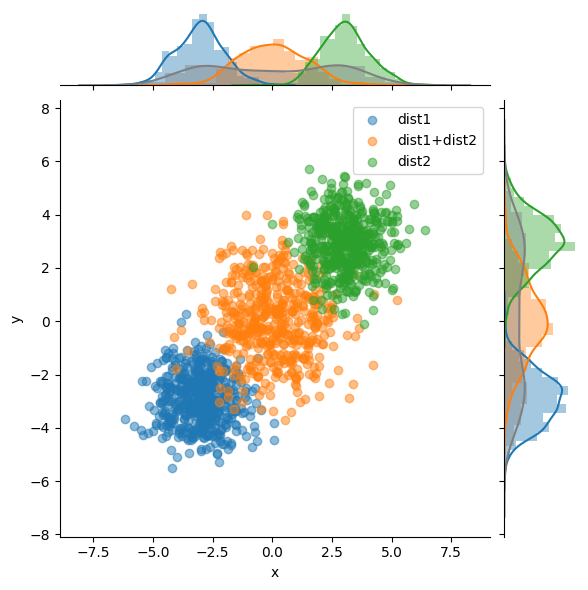

In [33]:
multivariateGrid('x', 'y', 'kind', df=df)

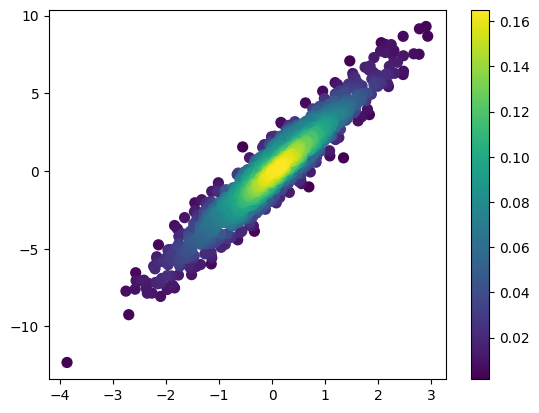

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=50)
plt.colorbar()
plt.show()

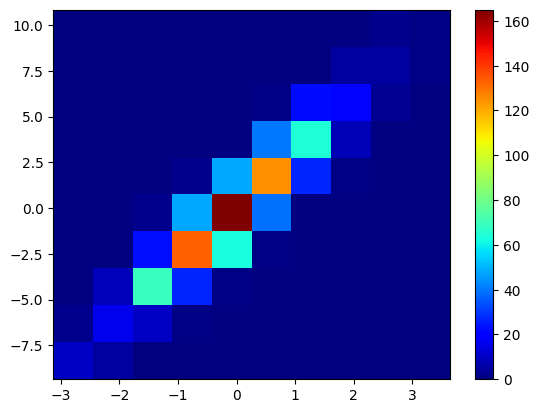

In [43]:
a = np.random.normal(size=1000)
b = a*3 + np.random.normal(size=1000)

plt.hist2d(a,b, cmap=plt.cm.jet)
plt.colorbar()

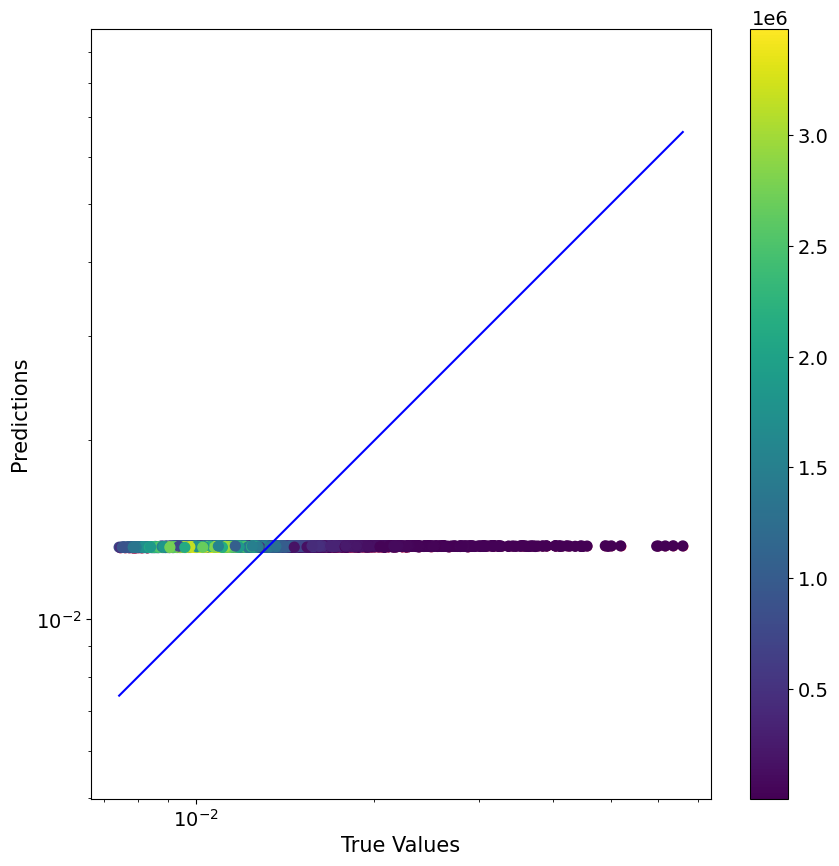

In [92]:
df = pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\test\\sobelnetwork_code\\predicted_data.csv")
true_value=df['test_y']
predicted_value=df['predict_y']
mac_number=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XT.dat",sep='\s+',names=[str(i) for i in range(0,16)])['15']
plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
# Calculate the point density
xy = np.vstack([true_value,mac_number])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = true_value[idx], predicted_value[idx], z[idx]

# fig, ax = plt.subplots()
plt.scatter(true_value, predicted_value, c=z, s=50)
plt.colorbar()

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


(0.006665954599192541,
 0.07373099642443126,
 0.01319647933692908,
 0.0802615211621678)

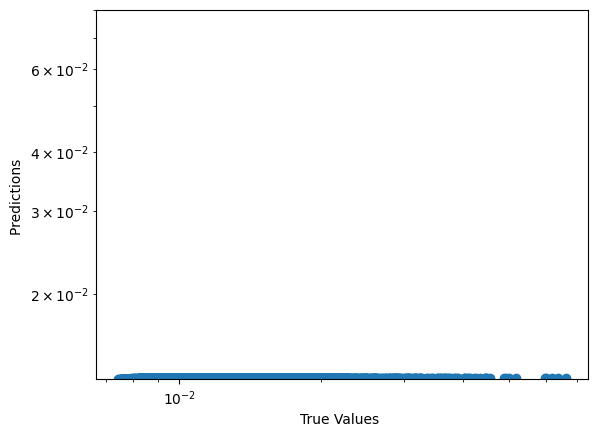

In [50]:
g=plt.scatter(true_value, predicted_value)
g.axes.set_yscale('log')
g.axes.set_xscale('log')
g.axes.set_xlabel('True Values ')
g.axes.set_ylabel('Predictions ')
g.axes.axis('equal')
g.axes.axis('square')

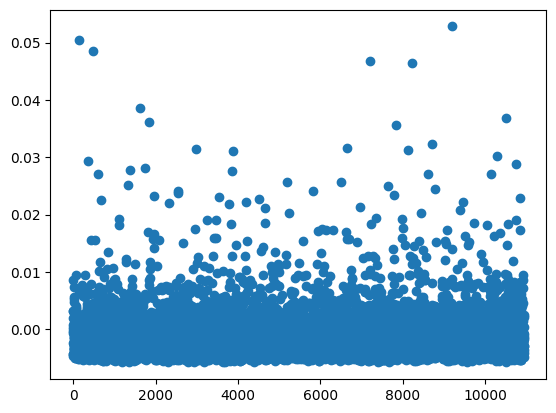

In [52]:
g=plt.plot(true_value - predicted_value,marker='o',linestyle='')

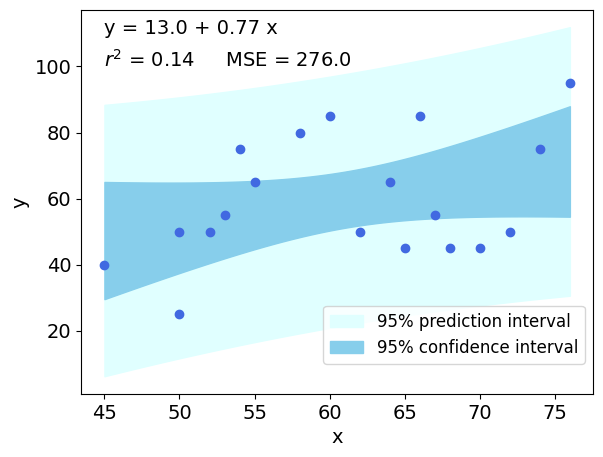

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

heights = np.array([50,52,53,54,58,60,62,64,66,67,68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,45,45,50,75,95,65,50,40,45])

x = heights
y = weights

slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([.1, .1, .8, .8])

ax.plot(x, y, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue')
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)

plt.legend(bbox_to_anchor=(1, .25), fontsize=12)


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [62]:
from sklearn import datasets
df = datasets.load_iris()
df.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [69]:
df.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [71]:
df=pd.DataFrame(df.data,columns=df.feature_names)

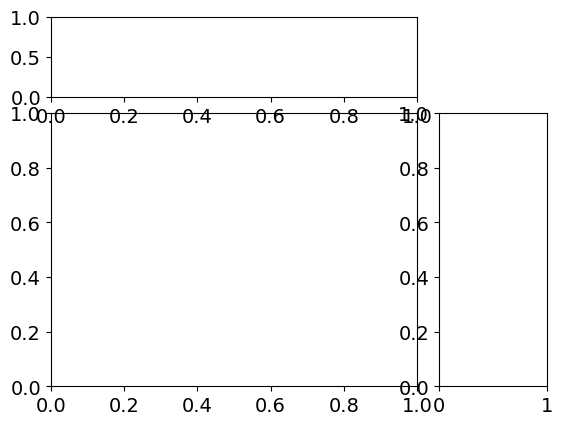

In [72]:
# df = pd.read_csv('iris.csv')

fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0,0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

plt.show()

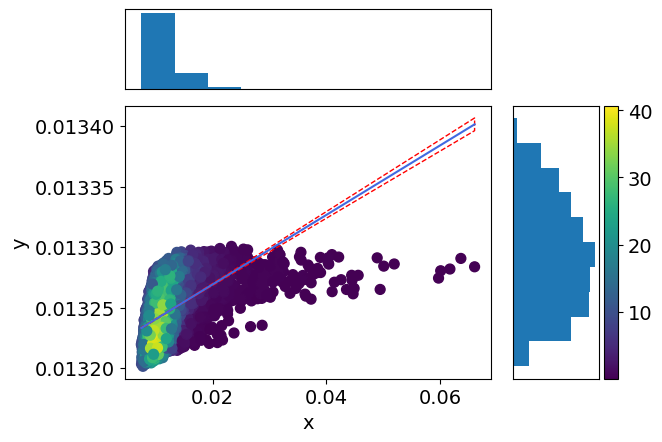

In [134]:
import pandas as pd,numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])
df = pd.read_csv("predicted_info.csv")
true_value=df['True_value']
predicted_value=df['Predicted_Value']
mac_number=df['Mach_No']
# true_value= df['sepal length (cm)']
# predicted_value= df['sepal width (cm)']

slope, intercept = np.polyfit(true_value, predicted_value, 1)

x_line = np.linspace(np.min(true_value), np.max(true_value), 100)
y_line = np.polyval([slope, intercept], x_line)


xy = np.vstack([true_value,mac_number])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = true_value[idx], predicted_value[idx], z[idx]

# fig, ax = plt.subplots()
im=ax_scatter.scatter(true_value, predicted_value, c=z, s=50)
m, b = np.polyfit(true_value, predicted_value, deg=1)
x_mean = np.mean(true_value)
# plot fitted y = m*x + b
# ax_scatter.axline(xy1=(0, b), slope=m, color='r')


y_model = np.polyval([slope, intercept], true_value)   # modeling...

x_mean = np.mean(true_value)
y_mean = np.mean(predicted_value)
n = true_value.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = predicted_value - y_model

std_error = (np.sum(residual**2) / dof)**.5 
 
# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((true_value - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((true_value - x_mean)**2))**.5  

# ax_scatter.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
ax_scatter.fill_between(x_line, y_line + ci, y_line - ci,linestyle='--', facecolor="none", edgecolor="red", linewidth=1.0, label = '95 confidence interval')
ax_scatter.plot(x_line, y_line, color = 'royalblue')
# ax_scatter.scatter(df['sepal length (cm)'], df['sepal width (cm)'])
ax_scatter.set_xlabel('x')
ax_scatter.set_ylabel('y')
ax_hist_x.hist(true_value)
ax_hist_x.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax_hist_y.hist(predicted_value, orientation = 'horizontal')
ax_hist_y.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.colorbar(im)

plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
flights = sns.load_dataset("flights")
# pivoting to make the data wide
flights = flights.pivot("month", "year", "passengers")
flights.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


In [5]:
sns.load_dataset("flights")

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


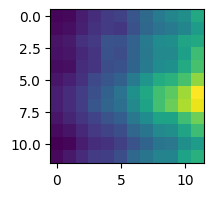

In [7]:
fig, ax = plt.subplots(figsize=(2,2))
im = ax.imshow(flights)

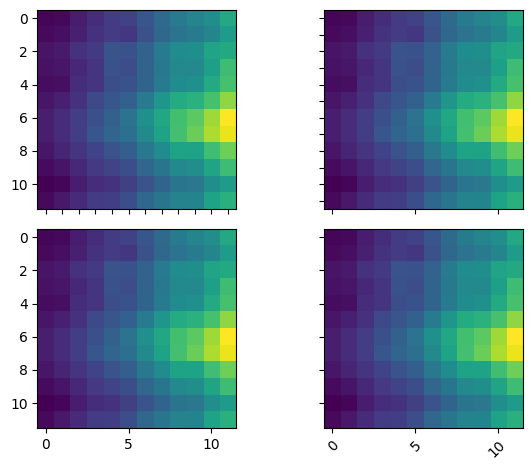

In [13]:
months = flights.index.values
months
years = flights.columns.values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im = ax1.imshow(flights)
ax2.imshow(flights)
ax3.imshow(flights)
ax4.imshow(flights)
cbar = ax1.figure.colorbar(im, 
                          ax = ax,
                          shrink=0.5 )
# add tick labels
ax1.set_xticks(np.arange(len(years)), 
              labels=years, 
              size=12)
ax2.set_yticks(np.arange(len(months)),
              labels=months,size=12)

for ax in fig.get_axes():
    ax.label_outer()
# Rotate the tick labels to be more legible
plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")
# ax.set_title("Flights Data Seaborn", size=20)
fig.tight_layout()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Sharing x per column, y per row')
ax1.plot(x, y)
ax2.plot(x, y**2, 'tab:orange')
ax3.plot(x, -y, 'tab:green')
ax4.plot(x, -y**2, 'tab:red')

for ax in fig.get_axes():
    ax.label_outer()

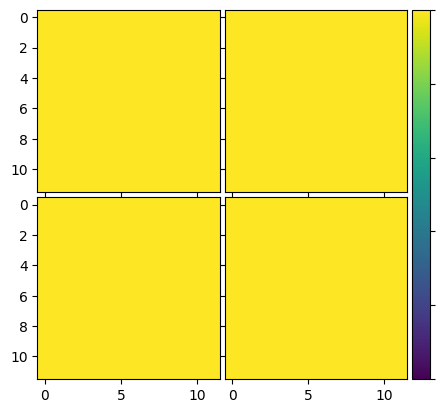

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Some random data
values1 = np.random.rand(10,10)
values2 = np.random.rand(10,10)
values3 = np.random.rand(10,10)
values4 = np.random.rand(10,10)
# vals = [values1,values2,values3,values4]
vals=[flights,flights,flights,flights]
fig = plt.figure()

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for val, ax in zip(vals,grid):
    im = ax.imshow(val, vmin=0, vmax=1)

grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(False)

plt.show()

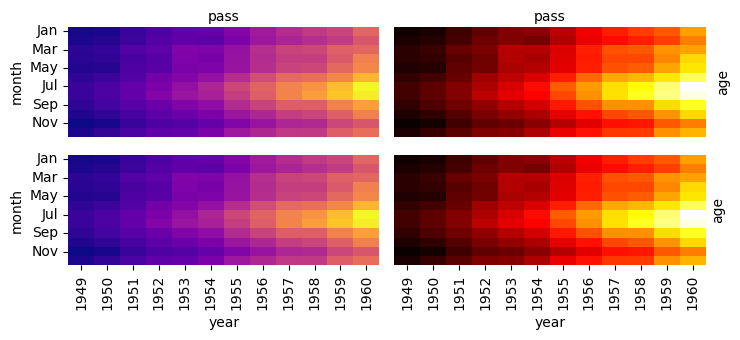

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# df1 = pd.DataFrame(np.random.rand(10, 4), columns=list("ABCD"))
# df2 = pd.DataFrame(np.random.rand(10, 4), columns=list("WXYZ"))

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2,nrows=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(flights, cmap="plasma", ax=ax1, cbar=False,xticklabels=False,cbar_kws = dict(use_gridspec=True,location="top"))
sns.heatmap(flights, cmap="hot", ax=ax2, cbar=False,xticklabels=False,yticklabels=False)
sns.heatmap(flights, cmap="plasma", ax=ax3, cbar=False)
sns.heatmap(flights, cmap="hot", ax=ax4, cbar=False,yticklabels=False)
ax2.yaxis.tick_right()
ax1.set(xlabel="pass")
ax1.xaxis.set_label_position("top")
ax2.set(xlabel="pass",ylabel="age")
ax2.xaxis.set_label_position("top")
ax2.yaxis.set_label_position("right")
ax4.set(ylabel="age")
ax4.yaxis.set_label_position("right")
fig.subplots_adjust(wspace=0.001)
# fig.colorbar(ax1.get_children()[0], cax=cax1, orientation="horizontal")
plt.show()

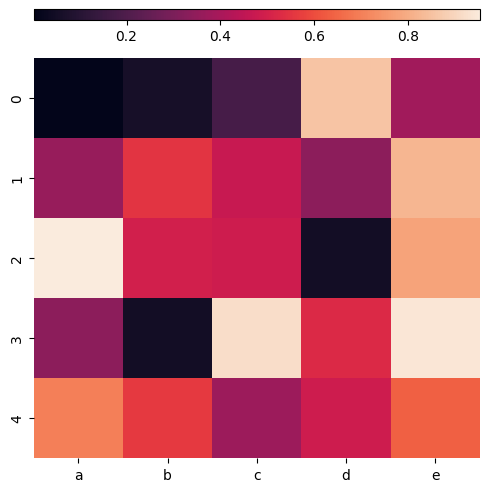

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create data
df = pd.DataFrame(np.random.random((5,5)), columns=["a","b","c","d","e"])

# Define two rows for subplots
fig, (cax, ax) = plt.subplots(nrows=2, figsize=(5,5.025),  gridspec_kw={"height_ratios":[0.025, 1]})

# Draw heatmap
sns.heatmap(df, ax=ax, cbar=False)
sns.heatmap(df, ax=cax, cbar=False)
# colorbar
fig.colorbar(ax.get_children()[0], cax=cax, orientation="horizontal")

plt.show()

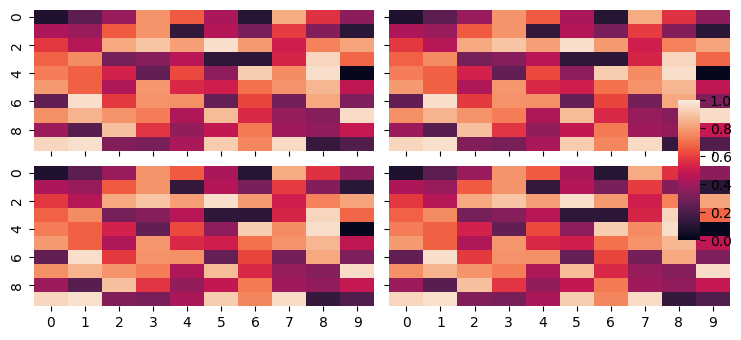

In [37]:
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    sns.heatmap(df, ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
